# Python notebook example

This is an example of running Python from a notebook. Note that we use some custom packages installed via the ``requirements.txt`` file. One of these came from a University git repository.

In [1]:
# Enable plotting support, etc. One could've folded this into the generic IPython
# configuration but I prefer to make it explicit.
%pylab inline
rcParams['figure.figsize'] = (16, 12)

Populating the interactive namespace from numpy and matplotlib


We're going to use the ``trafficutils`` library to try to load a representation of England's major road network from the UK Highways agency. Firstly, let's import the appropriate function:

In [2]:
import trafficutils.io as tio

Let's check the documentation for the function we're going to use:

In [3]:
help(tio.load_traffic_network)

Help on function load_traffic_network in module trafficutils.io:

load_traffic_network(filename_or_fobj, include_meta=False, include_optional=True)
    Load a traffic network from an XML document containing predefined links.
    
    Load the XML document from the file object or file name *filename_or_fobj*.
    
    Returns a networkx graph where each node is a (x,y) pair in WGS84. (There
    is also a pos field in each node which repeats the position.)
    
    If *include_meta* is True, additionally return a dictionary containing
    metadata about the network:
    
    {
        'publicationtime': datetime(<publication time in UTC>),
    }
    
    Each node's dictionary may optionally have the following fields:
    
    label: the node descriptor or None if empty
    ilc: a list of ILC (incident roads) on this junction
    
    Each edge's dictionary may optionally have the following fields:
    
    label: the link name
    id: a unique id for the link
    
    These fields are n

OK, let's use ``requests`` to download the XML document and then we'll pass it to ``load_traffic_network`` as a ``BytesIO`` object.

In [4]:
from requests import get

NETWORK_XML_URL="http://hatrafficinfo.dft.gov.uk/feeds/datex/England/PredefinedLocationLinks/content.xml"
network_xml_req = get(NETWORK_XML_URL)
assert network_xml_req.status_code == 200 # OK
network_xml = network_xml_req.content

In [5]:
from io import BytesIO
G = tio.load_traffic_network(BytesIO(network_xml))

How many nodes and links do we have?

In [6]:
print('nodes:', G.number_of_nodes())
print('edges:', G.number_of_edges())

nodes: 11465
edges: 12552


Let's try plotting it:

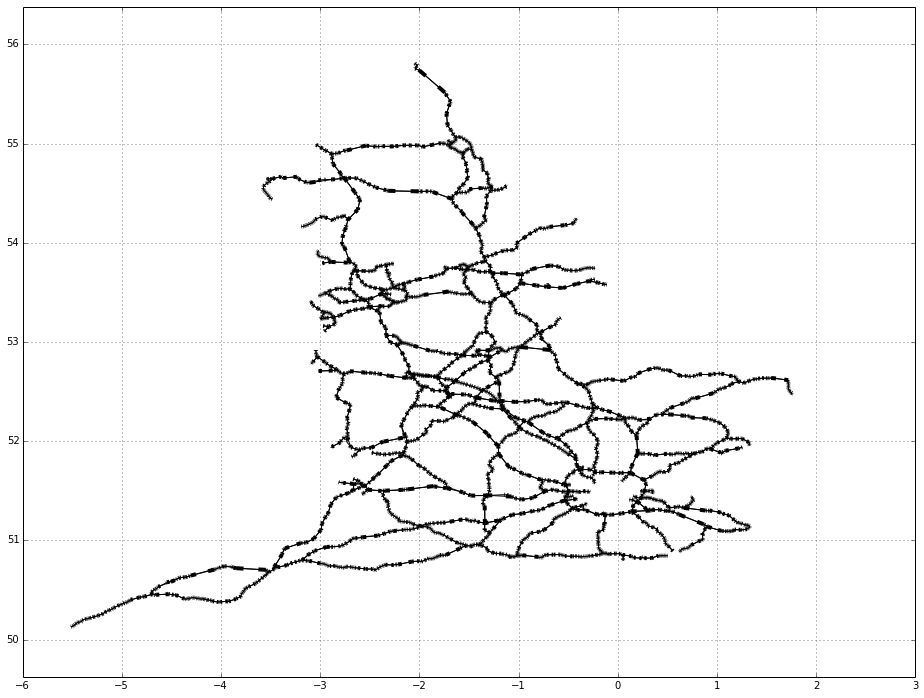

In [7]:
from networkx import draw_networkx, draw_networkx_edges

# The pos keyword argument is a dictionary mapping nodes to their (x, y) positions.
# Since the nodes are the (longitude, latitude) pairs we can just use the nodes as
# their own positions.
draw_networkx_edges(G, pos=dict((n,n) for n in G.nodes_iter()))
axis('equal')
grid('on')

It's a bit squashed what with the projection being raw latitudes and longitudes. Use the ``pyproj`` package to map from WGS84 latitude/longitude to the British National Grid.

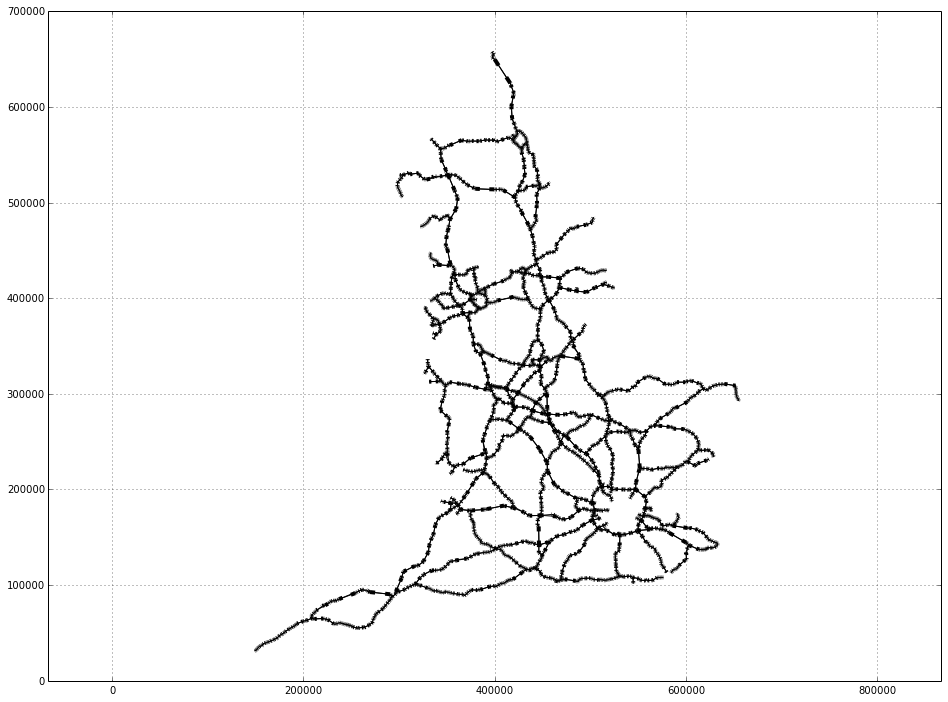

In [8]:
import pyproj

wgs84 = pyproj.Proj(init='epsg:4326')
bng = pyproj.Proj(init='epsg:27700')

draw_networkx_edges(G, pos=dict((n, pyproj.transform(wgs84, bng, *n)) for n in G.nodes_iter()))
axis('equal')
grid('on')